# Uvod u neuronske mreže
U ovom poglavlju prikazati ćemo kako izgraditi neuronski model za prepoznavanje osobe na slici. Kako bismo uspješno napravili model potrebno je oblikovati bazu podataka koja se sastoji od ručno označenih slika. Koristiti ćemo [LFW bazu podataka](http://vis-www.cs.umass.edu/lfw/) s minimalno 70 slika po osobi.

## Preuzimanje baze podataka

Kako bismo istrenirali klasifikator potrebno je prvenstveno skinupi podatke. Za skidanje podataka koristiti ćemo sklearn.datasets paket i metodu fetch_lfw_people. Ova metoda prihvaća argument minimalan broj lica po osobi i parametar resize koji skalira sliku na 40% od njene veličine.

In [1]:
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

Cijela baza se sastoji od 1288 slika označenih u ukupno 7 kategorija. Svala slika je dimenzija 50x37 sa vrijednostima piksela od 0 do 255. 0 označava nedostatak boje, a 255 označava puni intezitet boje. Kako bi podatci bili pogodni za ulaz u neuronsku mrežu potrebno je sliku pretvoriti u jednodimenzionalni niz (u lfw_people.data slike su pretvorene u jednodimentionalne nizove). Također je ulazni niz podataka potrebno pretvoriti u interval aktivacijske funkcije. A izlazni vektor je također potrebno kategorizirati, često se koristi metoda one-hot kodiranja numeričkih vrijednosti. Oznaka Y se pretvara u numeričku vrijednost od 1-7, a nakon toga numerička vrijednost se pretvara u kategoričku metodom to_categorical. Ovaj postupak sprječava neuronsku mrežu da uči poredak.

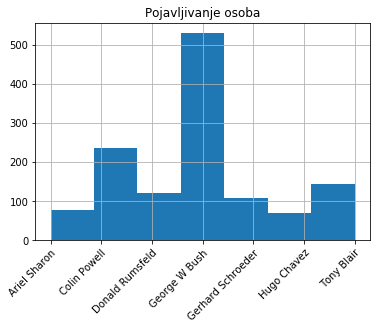

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.DataFrame({'Pojavljivanje osoba': lfw_people.target})
bin_names = np.insert(lfw_people.target_names,0, lfw_people.target_names[0])
histogram = df.hist(bins=7)
histogram[0][0].set_xticklabels(bin_names, rotation=45, rotation_mode="anchor", ha="right")
plt.show(histogram)

Podaci se skaliraju u interval od 0-1 i oznake se kodiraju u kategoričku vrijednost. Na ulazu je niz vektora koji se sastoje od 1850 neurona, a na izlazu je niz vektora koji se sastoje od 7 neurona.

In [3]:
from keras.utils import to_categorical

X = lfw_people.data / 255
y = to_categorical(lfw_people.target)
X.shape, y.shape

/home/daniel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


((1288, 1850), (1288, 7))

SLjedeći korak u izgradnji neuronske mreže je izgradnja neuronskog modela. U ovom sljučaju koristiti ćemo 2 skrivena sloja ulazni i izlazni sloj. Budući da je problem klasifikacije u više kategorija koje se međusobno isključuju najbolji izbor aktivacijske funkcije u izlaznom sloju [softmax](https://en.wikipedia.org/wiki/Softmax_function). U skrivenim slojevima koristiti ćemo relu aktivaciju koja daje bolje rezultate nego sigmoid funkcija. **Napomena: potrebno je eksperimentirati sa raznim modelima neuronske mreže kako bi dbili efikasan model.** Za optimizaciju koristiti ćemo Stochastic Gradient Descent algoritam koji omogućava brže računanje spusta funkcije, a funkcija gubitka koja je optimalna za ovaj problem je **categorical_crossentropy** koja omogućava treniranje neuronske mreže na kategoričke vrijednosti. Mreža sa ovim postavkama se sastoji od ukupno 738,007 parametara koji se mogu prilagoditi.

In [4]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(300, input_dim=X.shape[1], activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               555300    
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 2107      
Total params: 738,007
Trainable params: 738,007
Non-trainable params: 0
_________________________________________________________________


Kako bismo provjerili preciznost našeg modela potrebno je podjeliti skup za trenirnje u dvije kategorije. Podatke za treniranje i podataka za testiranje u omjeru 75:25. Kako bismo razdjelili ove podatke u sklearn paketu postoji metoda train_test_split koja ovo vrši prilično jednostavno. Metodi prosljeđujemo parametar test_size koji određuje u postotku veličinu podataka za treniranje i random_state koji nasumično premješta podatke kako neuronska mreža ne bi naučila poredak iz podataka.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Pozivom fit metode koja prima podatke za treniranje i oznake tih podataka te epoch parametar koji određuje u koliko navrate će se neuronska mreža trenirati što je veći broj epoha neuronska mreža se *bolje "uči"*, a batch size parametar određuje broj slika koja neuronska mreža obrađuje u fazi treniranja. 

In [6]:
model.fit(X_train, y_train, epochs=150, batch_size=10)

Epoch 1/150
966/966 [==============================] - 2s 2ms/step - loss: 1.6977 - acc: 0.3975
Epoch 2/150
966/966 [==============================] - 0s 375us/step - loss: 1.6231 - acc: 0.4275
Epoch 3/150
966/966 [==============================] - 0s 441us/step - loss: 1.5551 - acc: 0.4555
Epoch 4/150
966/966 [==============================] - 0s 382us/step - loss: 1.5295 - acc: 0.4576
Epoch 5/150
966/966 [==============================] - 0s 400us/step - loss: 1.4211 - acc: 0.4907
Epoch 6/150
966/966 [==============================] - 0s 389us/step - loss: 1.4035 - acc: 0.4979
Epoch 7/150
966/966 [==============================] - 0s 383us/step - loss: 1.3359 - acc: 0.5072
Epoch 8/150
966/966 [==============================] - 0s 396us/step - loss: 1.2906 - acc: 0.5186
Epoch 9/150
966/966 [==============================] - 0s 394us/step - loss: 1.2081 - acc: 0.5714
Epoch 10/150
966/966 [==============================] - 0s 382us/step - loss: 1.2020 - acc: 0.5528
Epoch 11/150
966/966 

966/966 [==============================] - 0s 263us/step - loss: 0.1459 - acc: 0.9472
Epoch 84/150
966/966 [==============================] - 0s 280us/step - loss: 0.1244 - acc: 0.9638
Epoch 85/150
966/966 [==============================] - 0s 265us/step - loss: 0.1400 - acc: 0.9576
Epoch 86/150
966/966 [==============================] - 0s 273us/step - loss: 0.1399 - acc: 0.9679
Epoch 87/150
966/966 [==============================] - 0s 270us/step - loss: 0.1089 - acc: 0.9679
Epoch 88/150
966/966 [==============================] - 0s 273us/step - loss: 0.4528 - acc: 0.9151
Epoch 89/150
966/966 [==============================] - 0s 290us/step - loss: 0.1101 - acc: 0.9648
Epoch 90/150
966/966 [==============================] - 0s 379us/step - loss: 0.0945 - acc: 0.9720
Epoch 91/150
966/966 [==============================] - 0s 302us/step - loss: 0.1493 - acc: 0.9658
Epoch 92/150
966/966 [==============================] - 0s 332us/step - loss: 0.2515 - acc: 0.9389
Epoch 93/150
966/966 [=

Kroz 150 epoha neuronska mreža je naučila klasificirati lica sa preciznosti od 100% međutim u podacima za testiranje primječujemo puno manju preciznost. Ovaj problem se zove **overfitting** gdje se neuronska mreža previše prilagodila podacima za treniranje. Kroz vrednovanje primječujemo preciznost od **84%**.

In [7]:
model.evaluate(X_test, y_test)

322/322 [==============================] - 0s 137us/step


[0.7636943785300166, 0.8354037267080745]

U nastavku implementirati ćemo metodu za prikaz slika u grid-u te prikazati samo one slike koje sustav nije ispravno klasificirao.

In [8]:
def plot_images(images, labels, n_row=3, n_col=4):
    titles = lfw_people.target_names
    n_samples, h, w = images.shape
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[labels[i]], size=12)
        plt.xticks(())
        plt.yticks(())

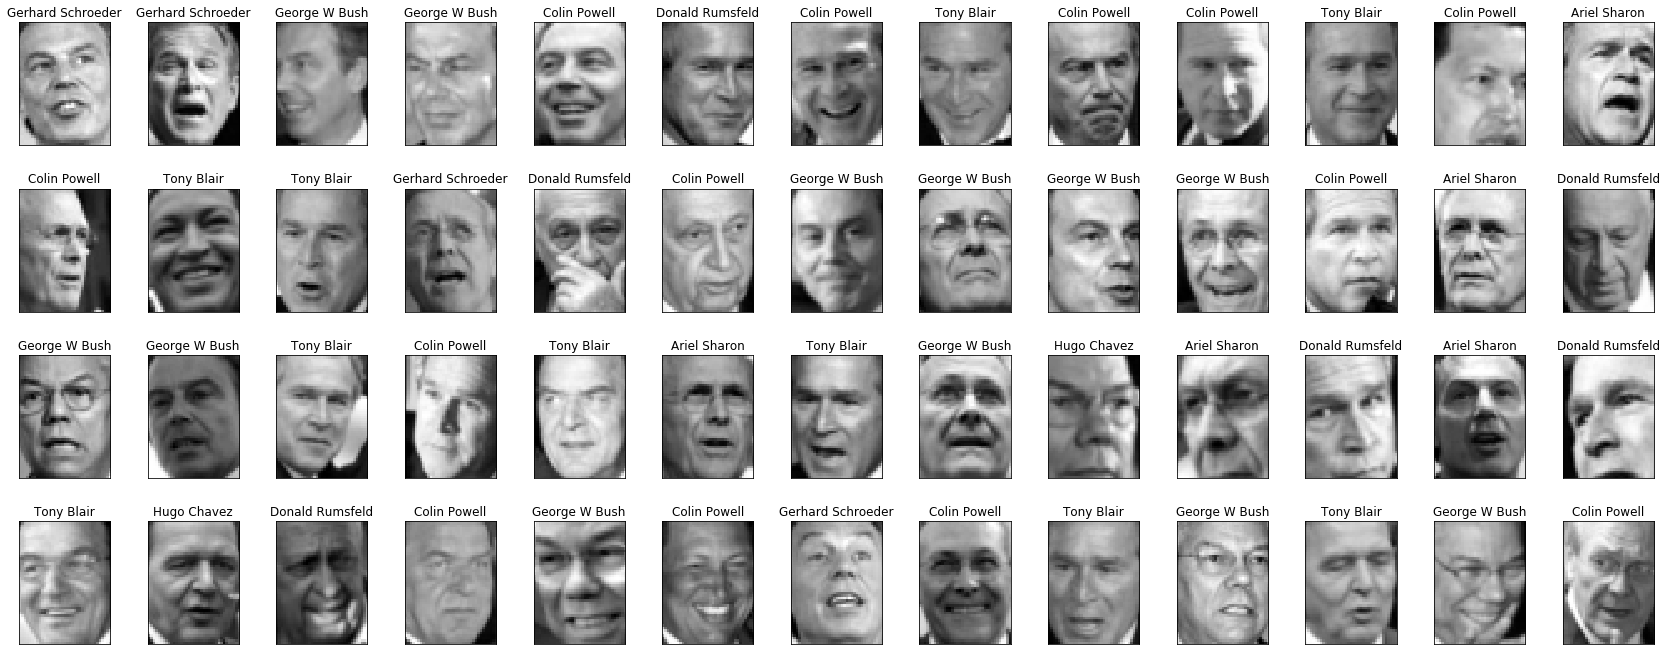

In [9]:
wrong_images, wrong_labels = [], []
test_data = X
test_labels = y

predict_labels = model.predict_classes(test_data)

for i, predict_label in enumerate(predict_labels):
    if predict_label != lfw_people.target[i]:
        wrong_images.append(lfw_people.images[i])
        wrong_labels.append(predict_label)
wrong_images = np.array(wrong_images)
wrong_labels = np.array(wrong_labels)
plot_images(wrong_images, wrong_labels, n_row=4, n_col=13)

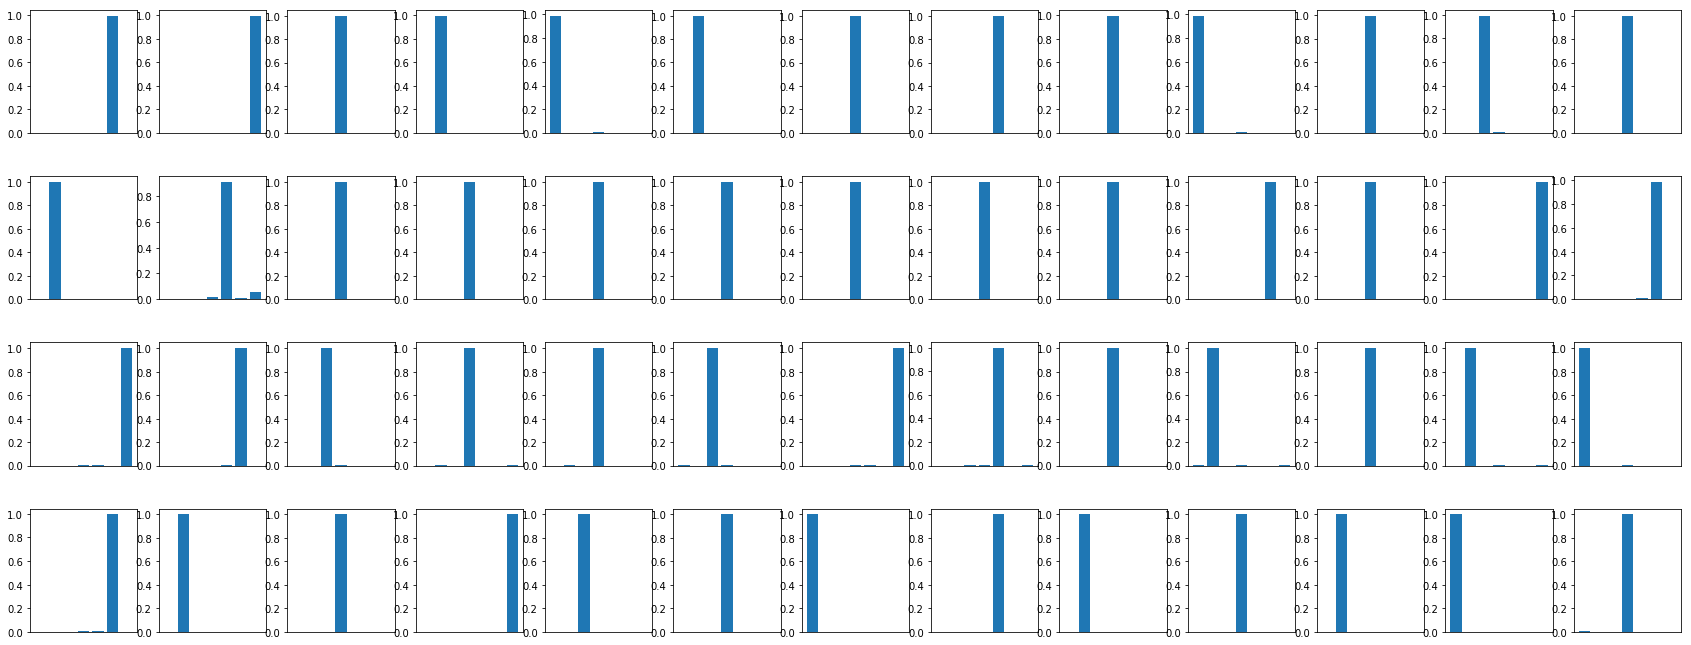

In [10]:
def plot_predictions(predictions, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.bar(range(7), predictions[i])
        plt.xticks(())
predictions = model.predict(test_data)
plot_predictions(predictions, n_row=4, n_col=13)